In [1]:
import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import xgboost as xgb
from sklearn.preprocessing import RobustScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix,roc_curve,classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler

pd.options.display.float_format = '{:,.3f}'.format
pd.set_option('display.max_columns', 100)

import warnings
warnings.filterwarnings('ignore')

In [2]:
df_full = pd.read_parquet("https://easy-money-project-bucket.s3.eu-west-3.amazonaws.com/df_full_cleaned.parquet")
df_full

,pk_cid,pk_partition,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,num_products_contracts,p_cuenta_bancaria,cuentas_sum,p_inversion,inversion_sum,p_financiacion,financiacion_sum,profit_cuentas,profit_inversion,profit_financiacion,country_id,gender,mes_partition,mes_nombre_partition,grupo_edad,median_salary,region_code,entry_date,entry_channel,active_customer,segment,categoria_antiguedad
0,1375586,2018-01-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,H,1,January,Adultos jóvenes,"87,218.100",Málaga,2018-01-12,Otros,1,02 - PARTICULARES,1-2 años
1,1050611,2018-01-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,V,1,January,Jóvenes,"35,548.740",Ciudad Real,2015-08-10,KHE,0,03 - UNIVERSITARIO,Más de 3 años
2,1050612,2018-01-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,V,1,January,Jóvenes,"122,179.110",Ciudad Real,2015-08-10,KHE,0,03 - UNIVERSITARIO,Más de 3 años
3,1050613,2018-01-28,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,40,0,ES,H,1,January,Jóvenes,"119,775.540",Zaragoza,2015-08-10,KHD,0,03 - UNIVERSITARIO,Más de 3 años
4,1050614,2018-01-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,V,1,January,Jóvenes,"101,469.135",Zaragoza,2015-08-10,KHE,1,03 - UNIVERSITARIO,Más de 3 años
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5962919,1166765,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,V,5,May,Jóvenes,"43,912.170",Zaragoza,2016-08-14,KHE,0,03 - UNIVERSITARIO,2-3 años
5962920,1166764,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,V,5,May,Jóvenes,"23,334.990","Rioja, La",2016-08-14,KHE,0,03 - UNIVERSITARIO,2-3 años
5962921,1166763,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,H,5,May,Adultos,"87,930.930",Zaragoza,2016-08-14,KHE,1,02 - PARTICULARES,2-3 años
5962922,1166789,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,H,5,May,Jóvenes,"199,592.820",Zaragoza,2016-08-14,KHE,0,03 - UNIVERSITARIO,2-3 años


Creamos una variable de "sale" para cada producto que permite capturar de manera eficiente el historial de contratación de productos por parte de los clientes. Este enfoque es útil porque:

Captura del comportamiento histórico del cliente: Aunque no puedes usar múltiples instancias del mismo cliente en distintas ingestas de datos, estas variables te permiten mantener información sobre si el cliente ha tenido o no un producto a lo largo del tiempo. Esto es clave, ya que el historial de productos previos puede influir en futuras decisiones de compra o contratación.

Facilita el entrenamiento del modelo: Al agregar una variable que indica si el cliente ha contratado un producto en algún momento, el modelo puede aprovechar esta información como un indicador de preferencia o comportamiento, mejorando la capacidad predictiva.

Reducción de duplicidad y ruido: Al consolidar el comportamiento histórico en una única variable por producto, se evita la redundancia y los posibles problemas de inconsistencia que podrían surgir al incluir múltiples filas del mismo cliente en diferentes fechas de ingesta.

In [3]:
def calculate_historical_sales(df, product_columns):
    # Crear un DataFrame temporal con solo las columnas de productos
    df_products = df[product_columns]
    
    # Calcular la suma de cada producto por cliente
    product_sums = df_products.groupby(df['pk_cid']).sum()
    
    # Convertir las sumas a 1 (si > 0) o 0
    product_sales = (product_sums > 0).astype(int)
    
    # Renombrar las columnas
    product_sales.columns = [f'sale_{col}' for col in product_sales.columns]
    
    # Fusionar los resultados con el DataFrame original
    return df.merge(product_sales, left_on='pk_cid', right_index=True, how='left')

# Lista de productos
product_columns = [
    'credit_card', 'short_term_deposit', 'loans', 'mortgage', 'funds',
    'securities', 'long_term_deposit', 'em_account_pp', 'payroll',
    'pension_plan', 'payroll_account', 'emc_account', 'debit_card',
    'em_account_p', 'em_acount'  # Nota: corregí 'em_acount' que estaba mal escrito en el original
]

# Aplicar la función
df_full = calculate_historical_sales(df_full, product_columns)

In [4]:
df_full[df_full['pk_cid'] == 1167274]

,pk_cid,pk_partition,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,num_products_contracts,p_cuenta_bancaria,cuentas_sum,p_inversion,inversion_sum,p_financiacion,financiacion_sum,profit_cuentas,profit_inversion,profit_financiacion,country_id,gender,mes_partition,mes_nombre_partition,grupo_edad,median_salary,region_code,entry_date,entry_channel,active_customer,segment,categoria_antiguedad,sale_credit_card,sale_short_term_deposit,sale_loans,sale_mortgage,sale_funds,sale_securities,sale_long_term_deposit,sale_em_account_pp,sale_payroll,sale_pension_plan,sale_payroll_account,sale_emc_account,sale_debit_card,sale_em_account_p,sale_em_acount
161673,1167274,2018-01-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,V,1,January,Jóvenes,"61,016.580",Salamanca,2016-08-19,KHE,1,03 - UNIVERSITARIO,2-3 años,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
313183,1167274,2018-02-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,V,2,February,Jóvenes,"61,016.580",Salamanca,2016-08-19,KHE,1,03 - UNIVERSITARIO,2-3 años,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
531223,1167274,2018-03-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,V,3,March,Jóvenes,"61,016.580",Salamanca,2016-08-19,KHE,1,03 - UNIVERSITARIO,2-3 años,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
775879,1167274,2018-04-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,V,4,April,Jóvenes,"61,016.580",Salamanca,2016-08-19,KHE,1,03 - UNIVERSITARIO,2-3 años,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
1173970,1167274,2018-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,V,5,May,Jóvenes,"61,016.580",Salamanca,2016-08-19,KHE,1,03 - UNIVERSITARIO,2-3 años,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
1427338,1167274,2018-06-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,V,6,June,Jóvenes,"61,016.580",Salamanca,2016-08-19,KHE,1,03 - UNIVERSITARIO,2-3 años,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
1536602,1167274,2018-07-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,V,7,July,Jóvenes,"61,016.580",Salamanca,2016-08-19,KHE,1,03 - UNIVERSITARIO,2-3 años,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
2158307,1167274,2018-08-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,V,8,August,Jóvenes,"61,016.580",Salamanca,2016-08-19,KHE,1,03 - UNIVERSITARIO,2-3 años,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
2392691,1167274,2018-09-28,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,2,1,2,0,0,0,0,20,0,0,ES,V,9,September,Jóvenes,"61,016.580",Salamanca,2016-08-19,KHE,1,03 - UNIVERSITARIO,2-3 años,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
2647752,1167274,2018-10-28,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,2,1,2,0,0,0,0,20,0,0,ES,V,10,October,Jóvenes,"61,016.580",Salamanca,2016-08-19,KHE,1,03 - UNIVERSITARIO,2-3 años,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1


In [5]:
df_full

,pk_cid,pk_partition,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,num_products_contracts,p_cuenta_bancaria,cuentas_sum,p_inversion,inversion_sum,p_financiacion,financiacion_sum,profit_cuentas,profit_inversion,profit_financiacion,country_id,gender,mes_partition,mes_nombre_partition,grupo_edad,median_salary,region_code,entry_date,entry_channel,active_customer,segment,categoria_antiguedad,sale_credit_card,sale_short_term_deposit,sale_loans,sale_mortgage,sale_funds,sale_securities,sale_long_term_deposit,sale_em_account_pp,sale_payroll,sale_pension_plan,sale_payroll_account,sale_emc_account,sale_debit_card,sale_em_account_p,sale_em_acount
0,1375586,2018-01-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,H,1,January,Adultos jóvenes,"87,218.100",Málaga,2018-01-12,Otros,1,02 - PARTICULARES,1-2 años,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
1,1050611,2018-01-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,V,1,January,Jóvenes,"35,548.740",Ciudad Real,2015-08-10,KHE,0,03 - UNIVERSITARIO,Más de 3 años,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,1050612,2018-01-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,V,1,January,Jóvenes,"122,179.110",Ciudad Real,2015-08-10,KHE,0,03 - UNIVERSITARIO,Más de 3 años,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,1050613,2018-01-28,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,40,0,ES,H,1,January,Jóvenes,"119,775.540",Zaragoza,2015-08-10,KHD,0,03 - UNIVERSITARIO,Más de 3 años,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1050614,2018-01-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,V,1,January,Jóvenes,"101,469.135",Zaragoza,2015-08-10,KHE,1,03 - UNIVERSITARIO,Más de 3 años,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5962919,1166765,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,V,5,May,Jóvenes,"43,912.170",Zaragoza,2016-08-14,KHE,0,03 - UNIVERSITARIO,2-3 años,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
5962920,1166764,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,V,5,May,Jóvenes,"23,334.990","Rioja, La",2016-08-14,KHE,0,03 - UNIVERSITARIO,2-3 años,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
5962921,1166763,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,H,5,May,Adultos,"87,930.930",Zaragoza,2016-08-14,KHE,1,02 - PARTICULARES,2-3 años,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
5962922,1166789,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,H,5,May,Jóvenes,"199,592.820",Zaragoza,2016-08-14,KHE,0,03 - UNIVERSITARIO,2-3 años,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [6]:
df_full[df_full['pk_cid'] == 1050613]

,pk_cid,pk_partition,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,num_products_contracts,p_cuenta_bancaria,cuentas_sum,p_inversion,inversion_sum,p_financiacion,financiacion_sum,profit_cuentas,profit_inversion,profit_financiacion,country_id,gender,mes_partition,mes_nombre_partition,grupo_edad,median_salary,region_code,entry_date,entry_channel,active_customer,segment,categoria_antiguedad,sale_credit_card,sale_short_term_deposit,sale_loans,sale_mortgage,sale_funds,sale_securities,sale_long_term_deposit,sale_em_account_pp,sale_payroll,sale_pension_plan,sale_payroll_account,sale_emc_account,sale_debit_card,sale_em_account_p,sale_em_acount
3,1050613,2018-01-28,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,40,0,ES,H,1,January,Jóvenes,"119,775.540",Zaragoza,2015-08-10,KHD,0,03 - UNIVERSITARIO,Más de 3 años,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
472596,1050613,2018-02-28,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,40,0,ES,H,2,February,Jóvenes,"119,775.540",Zaragoza,2015-08-10,KHD,0,03 - UNIVERSITARIO,Más de 3 años,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
693180,1050613,2018-03-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,ES,H,3,March,Jóvenes,"119,775.540",Zaragoza,2015-08-10,KHD,0,03 - UNIVERSITARIO,Más de 3 años,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1581538,1050613,2018-07-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,ES,H,7,July,Jóvenes,"119,775.540",Zaragoza,2015-08-10,KHD,0,03 - UNIVERSITARIO,Más de 3 años,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2050117,1050613,2018-08-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,ES,H,8,August,Jóvenes,"119,775.540",Zaragoza,2015-08-10,KHD,0,03 - UNIVERSITARIO,Más de 3 años,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2331062,1050613,2018-09-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,ES,H,9,September,Jóvenes,"119,775.540",Zaragoza,2015-08-10,KHD,0,03 - UNIVERSITARIO,Más de 3 años,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2673594,1050613,2018-10-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,ES,H,10,October,Jóvenes,"119,775.540",Zaragoza,2015-08-10,KHD,0,03 - UNIVERSITARIO,Más de 3 años,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3335098,1050613,2018-11-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,ES,H,11,November,Jóvenes,"119,775.540",Zaragoza,2015-08-10,KHD,0,03 - UNIVERSITARIO,Más de 3 años,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3416910,1050613,2018-12-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,ES,H,12,December,Jóvenes,"119,775.540",Zaragoza,2015-08-10,KHD,0,03 - UNIVERSITARIO,Más de 3 años,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4162354,1050613,2019-01-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,ES,H,1,January,Jóvenes,"119,775.540",Zaragoza,2015-08-10,KHD,0,03 - UNIVERSITARIO,Más de 3 años,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [7]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5962924 entries, 0 to 5962923
Data columns (total 54 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   pk_cid                   int64         
 1   pk_partition             datetime64[ns]
 2   short_term_deposit       int8          
 3   loans                    int8          
 4   mortgage                 int8          
 5   funds                    int8          
 6   securities               int8          
 7   long_term_deposit        int8          
 8   em_account_pp            int8          
 9   credit_card              int8          
 10  payroll                  int8          
 11  pension_plan             int8          
 12  payroll_account          int8          
 13  emc_account              int8          
 14  debit_card               int8          
 15  em_account_p             int8          
 16  em_acount                int8          
 17  num_products_contracts   in

In [8]:
df_full = df_full[df_full["pk_partition"] == "2019-05-28"]

In [9]:
# df_last_view = df_full.drop_duplicates(subset='pk_cid', keep='last').reset_index(drop=True)


In [10]:
df = df_full

In [11]:
df['credit_card'].value_counts()

credit_card
0    438194
1      4801
Name: count, dtype: int64

In [13]:
df

,pk_cid,pk_partition,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,num_products_contracts,p_cuenta_bancaria,cuentas_sum,p_inversion,inversion_sum,p_financiacion,financiacion_sum,profit_cuentas,profit_inversion,profit_financiacion,country_id,gender,mes_partition,mes_nombre_partition,grupo_edad,median_salary,region_code,entry_date,entry_channel,active_customer,segment,categoria_antiguedad,sale_credit_card,sale_short_term_deposit,sale_loans,sale_mortgage,sale_funds,sale_securities,sale_long_term_deposit,sale_em_account_pp,sale_payroll,sale_pension_plan,sale_payroll_account,sale_emc_account,sale_debit_card,sale_em_account_p,sale_em_acount
5519929,657826,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,H,5,May,Adultos,"54,493.380",Lleida,2015-05-24,Otros,1,02 - PARTICULARES,Más de 3 años,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
5519930,657817,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,ES,V,5,May,Adultos jóvenes,"120,141.600",Barcelona,2019-05-12,Otros,0,03 - UNIVERSITARIO,0-3 meses,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5519931,657986,2019-05-28,0,0,0,0,0,0,0,1,1,1,1,1,1,0,0,6,1,4,1,1,1,1,40,40,60,ES,H,5,May,Adultos jóvenes,"100,993.170",Sevilla,2016-02-18,Otros,1,02 - PARTICULARES,Más de 3 años,1,0,0,0,0,0,0,0,1,1,1,1,1,0,0
5519932,657905,2019-05-28,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,2,1,1,1,1,0,0,10,40,0,ES,H,5,May,Longevos,"154,059.090",Madrid,2017-02-07,KAT,1,01 - TOP,2-3 años,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
5519933,657336,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,V,5,May,Adultos jóvenes,"108,223.410",Madrid,2019-03-28,KAT,1,02 - PARTICULARES,0-3 meses,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5962919,1166765,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,V,5,May,Jóvenes,"43,912.170",Zaragoza,2016-08-14,KHE,0,03 - UNIVERSITARIO,2-3 años,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
5962920,1166764,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,V,5,May,Jóvenes,"23,334.990","Rioja, La",2016-08-14,KHE,0,03 - UNIVERSITARIO,2-3 años,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
5962921,1166763,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,H,5,May,Adultos,"87,930.930",Zaragoza,2016-08-14,KHE,1,02 - PARTICULARES,2-3 años,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
5962922,1166789,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,H,5,May,Jóvenes,"199,592.820",Zaragoza,2016-08-14,KHE,0,03 - UNIVERSITARIO,2-3 años,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 442995 entries, 5519929 to 5962923
Data columns (total 54 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   pk_cid                   442995 non-null  int64         
 1   pk_partition             442995 non-null  datetime64[ns]
 2   short_term_deposit       442995 non-null  int8          
 3   loans                    442995 non-null  int8          
 4   mortgage                 442995 non-null  int8          
 5   funds                    442995 non-null  int8          
 6   securities               442995 non-null  int8          
 7   long_term_deposit        442995 non-null  int8          
 8   em_account_pp            442995 non-null  int8          
 9   credit_card              442995 non-null  int8          
 10  payroll                  442995 non-null  int8          
 11  pension_plan             442995 non-null  int8          
 12  payroll_accoun

In [15]:
df.drop('entry_date', axis=1, inplace=True)
df.drop('credit_card', axis=1, inplace=True)
df.drop('country_id', axis=1, inplace=True)
df.drop('pk_partition', axis=1, inplace=True)
df.set_index('pk_cid', inplace=True)

In [16]:
df['entry_channel'].value_counts()

entry_channel
KHE      194835
KHQ       75026
KFC       59151
KHM       30248
KAT       26343
KHK       16318
KHN       15967
Otros     11062
KFA        4966
KHD        4826
RED        4253
Name: count, dtype: int64

In [17]:
df

,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,num_products_contracts,p_cuenta_bancaria,cuentas_sum,p_inversion,inversion_sum,p_financiacion,financiacion_sum,profit_cuentas,profit_inversion,profit_financiacion,gender,mes_partition,mes_nombre_partition,grupo_edad,median_salary,region_code,entry_channel,active_customer,segment,categoria_antiguedad,sale_credit_card,sale_short_term_deposit,sale_loans,sale_mortgage,sale_funds,sale_securities,sale_long_term_deposit,sale_em_account_pp,sale_payroll,sale_pension_plan,sale_payroll_account,sale_emc_account,sale_debit_card,sale_em_account_p,sale_em_acount
pk_cid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
657826,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,H,5,May,Adultos,"54,493.380",Lleida,Otros,1,02 - PARTICULARES,Más de 3 años,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
657817,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,V,5,May,Adultos jóvenes,"120,141.600",Barcelona,Otros,0,03 - UNIVERSITARIO,0-3 meses,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
657986,0,0,0,0,0,0,0,1,1,1,1,1,0,0,6,1,4,1,1,1,1,40,40,60,H,5,May,Adultos jóvenes,"100,993.170",Sevilla,Otros,1,02 - PARTICULARES,Más de 3 años,1,0,0,0,0,0,0,0,1,1,1,1,1,0,0
657905,0,0,0,0,0,1,0,0,0,0,0,0,0,1,2,1,1,1,1,0,0,10,40,0,H,5,May,Longevos,"154,059.090",Madrid,KAT,1,01 - TOP,2-3 años,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
657336,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,V,5,May,Adultos jóvenes,"108,223.410",Madrid,KAT,1,02 - PARTICULARES,0-3 meses,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1166765,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,V,5,May,Jóvenes,"43,912.170",Zaragoza,KHE,0,03 - UNIVERSITARIO,2-3 años,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1166764,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,V,5,May,Jóvenes,"23,334.990","Rioja, La",KHE,0,03 - UNIVERSITARIO,2-3 años,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
1166763,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,H,5,May,Adultos,"87,930.930",Zaragoza,KHE,1,02 - PARTICULARES,2-3 años,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [18]:
# Preparar las características (X) y la variable objetivo (y)
X = df.drop(columns=['sale_credit_card'])
y = df['sale_credit_card']


In [19]:
y.value_counts()

sale_credit_card
0    434562
1      8433
Name: count, dtype: int64

In [20]:

# Crear un modelo de undersampling
undersampler = RandomUnderSampler(random_state=42)  # Establece un random seed para reproducibilidad
X_resampled, y_resampled = undersampler.fit_resample(X, y)


In [21]:
y_resampled.value_counts()

sale_credit_card
0    8433
1    8433
Name: count, dtype: int64

In [22]:
# One-Hot Encoding para las variables categóricas
categorical_cols = X_resampled.select_dtypes(include=['object', 'category']).columns
ohe = OneHotEncoder(sparse_output=False, drop='first')
X_ohe = pd.DataFrame(ohe.fit_transform(X_resampled[categorical_cols]), 
                    columns=ohe.get_feature_names_out(categorical_cols), index=X_resampled.index)


In [23]:
# RobustScaler para las variables numéricas
numerical_cols = X_resampled.select_dtypes(include=['int64', 'float64','int32','int8']).columns
scaler = RobustScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_resampled[numerical_cols]), 
                        columns=numerical_cols, index=X_resampled.index)


In [24]:
# Combinar las columnas procesadas
X_processed = pd.concat([X_scaled, X_ohe], axis=1)

In [25]:
X_processed

,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,num_products_contracts,p_cuenta_bancaria,cuentas_sum,p_inversion,inversion_sum,p_financiacion,financiacion_sum,profit_cuentas,profit_inversion,profit_financiacion,mes_partition,median_salary,active_customer,sale_short_term_deposit,sale_loans,sale_mortgage,sale_funds,sale_securities,sale_long_term_deposit,sale_em_account_pp,sale_payroll,sale_pension_plan,sale_payroll_account,sale_emc_account,sale_debit_card,sale_em_account_p,sale_em_acount,gender_V,grupo_edad_Adultos jóvenes,grupo_edad_Adultos mayores,grupo_edad_Ancianos,grupo_edad_Jóvenes,grupo_edad_Longevos,grupo_edad_Menores,region_code_Alicante,region_code_Almería,...,region_code_Granada,region_code_Guadalajara,region_code_Huelva,region_code_Huesca,region_code_Jaén,region_code_León,region_code_Lleida,region_code_Lugo,region_code_Madrid,region_code_Melilla,region_code_Murcia,region_code_Málaga,region_code_Navarra,region_code_Ourense,region_code_Palencia,"region_code_Palmas, Las",region_code_Pontevedra,"region_code_Rioja, La",region_code_Salamanca,region_code_Santa Cruz de Tenerife,region_code_Segovia,region_code_Sevilla,region_code_Soria,region_code_Tarragona,region_code_Teruel,region_code_Toledo,region_code_Valencia,region_code_Valladolid,region_code_Zamora,region_code_Zaragoza,region_code_Álava,region_code_Ávila,entry_channel_KFA,entry_channel_KFC,entry_channel_KHD,entry_channel_KHE,entry_channel_KHK,entry_channel_KHM,entry_channel_KHN,entry_channel_KHQ,entry_channel_Otros,entry_channel_RED,segment_02 - PARTICULARES,segment_03 - UNIVERSITARIO,categoria_antiguedad_1-2 años,categoria_antiguedad_2-3 años,categoria_antiguedad_3-6 meses,categoria_antiguedad_6-9 meses,categoria_antiguedad_9-12 meses,categoria_antiguedad_Más de 3 años
pk_cid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1027066,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.400,-1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000
1522994,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.416,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000
1525552,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.500,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,-0.253,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000
1404548,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,1.000,1.000,1.000,0.000,-1.000,2.000,0.000,3.000,1.000,1.000,0.000,0.000,3.000,40.000,0.000,0.000,-0.655,0.000,0

In [26]:
X_processed.index.nunique()

16866

In [27]:
# Separar el conjunto en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_processed, y_resampled, test_size=0.3, random_state=42)


In [28]:
# Crear el modelo de XGBoost
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

In [29]:
# Entrenar el modelo
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [30]:
# Hacer predicciones
y_pred = xgb_model.predict(X_test)
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]  # Probabilidades de clase positiva

In [31]:
# Calcular métricas
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)


In [32]:
# Imprimir métricas
print(f"Accuracy: {accuracy:.2f}")
print(f"ROC AUC: {roc_auc:.2f}")
print("\nClassification Report:\n", class_report)

Accuracy: 0.90
ROC AUC: 0.97

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.89      0.90      2566
           1       0.89      0.91      0.90      2494

    accuracy                           0.90      5060
   macro avg       0.90      0.90      0.90      5060
weighted avg       0.90      0.90      0.90      5060



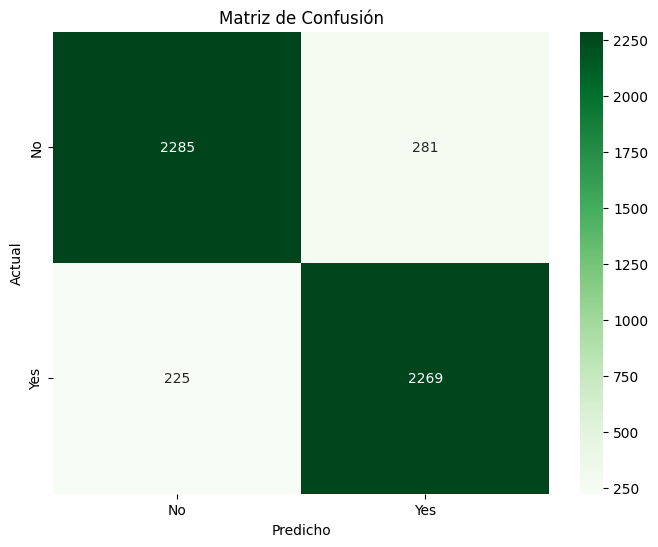

In [33]:
# Gráfico de la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.ylabel('Actual')
plt.xlabel('Predicho')
plt.title('Matriz de Confusión')
plt.show()

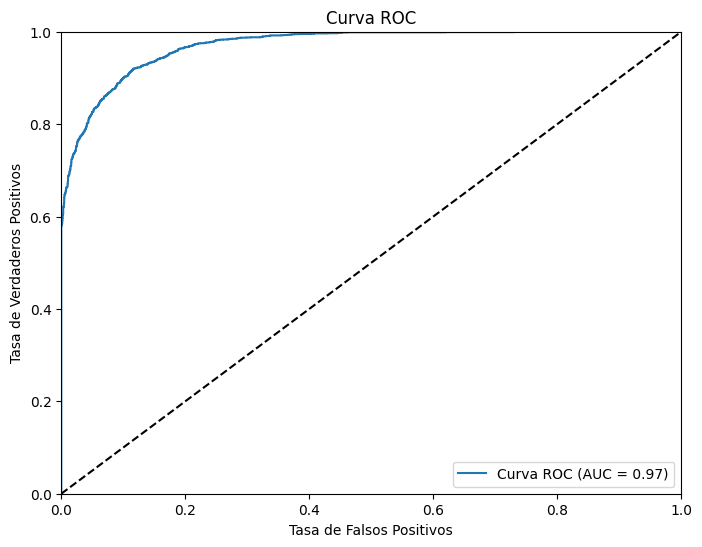

In [34]:
# Gráfico de la curva ROC AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='Curva ROC (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')  # Línea diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

In [35]:
df_last = df

In [36]:
df_last

,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,num_products_contracts,p_cuenta_bancaria,cuentas_sum,p_inversion,inversion_sum,p_financiacion,financiacion_sum,profit_cuentas,profit_inversion,profit_financiacion,gender,mes_partition,mes_nombre_partition,grupo_edad,median_salary,region_code,entry_channel,active_customer,segment,categoria_antiguedad,sale_credit_card,sale_short_term_deposit,sale_loans,sale_mortgage,sale_funds,sale_securities,sale_long_term_deposit,sale_em_account_pp,sale_payroll,sale_pension_plan,sale_payroll_account,sale_emc_account,sale_debit_card,sale_em_account_p,sale_em_acount
pk_cid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
657826,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,H,5,May,Adultos,"54,493.380",Lleida,Otros,1,02 - PARTICULARES,Más de 3 años,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
657817,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,V,5,May,Adultos jóvenes,"120,141.600",Barcelona,Otros,0,03 - UNIVERSITARIO,0-3 meses,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
657986,0,0,0,0,0,0,0,1,1,1,1,1,0,0,6,1,4,1,1,1,1,40,40,60,H,5,May,Adultos jóvenes,"100,993.170",Sevilla,Otros,1,02 - PARTICULARES,Más de 3 años,1,0,0,0,0,0,0,0,1,1,1,1,1,0,0
657905,0,0,0,0,0,1,0,0,0,0,0,0,0,1,2,1,1,1,1,0,0,10,40,0,H,5,May,Longevos,"154,059.090",Madrid,KAT,1,01 - TOP,2-3 años,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
657336,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,V,5,May,Adultos jóvenes,"108,223.410",Madrid,KAT,1,02 - PARTICULARES,0-3 meses,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1166765,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,V,5,May,Jóvenes,"43,912.170",Zaragoza,KHE,0,03 - UNIVERSITARIO,2-3 años,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1166764,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,V,5,May,Jóvenes,"23,334.990","Rioja, La",KHE,0,03 - UNIVERSITARIO,2-3 años,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
1166763,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,H,5,May,Adultos,"87,930.930",Zaragoza,KHE,1,02 - PARTICULARES,2-3 años,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [38]:
df_customers_no_credit_card = df_last[df_last['sale_credit_card'] == 0]


In [40]:
df_customers_no_credit_card['sale_credit_card'].value_counts()

sale_credit_card
0    434562
Name: count, dtype: int64

In [41]:
df_customers_no_credit_card

,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,num_products_contracts,p_cuenta_bancaria,cuentas_sum,p_inversion,inversion_sum,p_financiacion,financiacion_sum,profit_cuentas,profit_inversion,profit_financiacion,gender,mes_partition,mes_nombre_partition,grupo_edad,median_salary,region_code,entry_channel,active_customer,segment,categoria_antiguedad,sale_credit_card,sale_short_term_deposit,sale_loans,sale_mortgage,sale_funds,sale_securities,sale_long_term_deposit,sale_em_account_pp,sale_payroll,sale_pension_plan,sale_payroll_account,sale_emc_account,sale_debit_card,sale_em_account_p,sale_em_acount
pk_cid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
657826,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,H,5,May,Adultos,"54,493.380",Lleida,Otros,1,02 - PARTICULARES,Más de 3 años,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
657817,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,V,5,May,Adultos jóvenes,"120,141.600",Barcelona,Otros,0,03 - UNIVERSITARIO,0-3 meses,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
657905,0,0,0,0,0,1,0,0,0,0,0,0,0,1,2,1,1,1,1,0,0,10,40,0,H,5,May,Longevos,"154,059.090",Madrid,KAT,1,01 - TOP,2-3 años,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
657336,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,V,5,May,Adultos jóvenes,"108,223.410",Madrid,KAT,1,02 - PARTICULARES,0-3 meses,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
657147,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,H,5,May,Adultos mayores,"104,881.710",Madrid,KAT,0,02 - PARTICULARES,1-2 años,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1166765,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,V,5,May,Jóvenes,"43,912.170",Zaragoza,KHE,0,03 - UNIVERSITARIO,2-3 años,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1166764,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,V,5,May,Jóvenes,"23,334.990","Rioja, La",KHE,0,03 - UNIVERSITARIO,2-3 años,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
1166763,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,H,5,May,Adultos,"87,930.930",Zaragoza,KHE,1,02 - PARTICULARES,2-3 años,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [43]:
# Obtener las características (X) de los clientes sin tarjeta de crédito
X_no_credit_card = df_customers_no_credit_card.drop(columns=['sale_credit_card'])

In [44]:
X_no_credit_card

,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,num_products_contracts,p_cuenta_bancaria,cuentas_sum,p_inversion,inversion_sum,p_financiacion,financiacion_sum,profit_cuentas,profit_inversion,profit_financiacion,gender,mes_partition,mes_nombre_partition,grupo_edad,median_salary,region_code,entry_channel,active_customer,segment,categoria_antiguedad,sale_short_term_deposit,sale_loans,sale_mortgage,sale_funds,sale_securities,sale_long_term_deposit,sale_em_account_pp,sale_payroll,sale_pension_plan,sale_payroll_account,sale_emc_account,sale_debit_card,sale_em_account_p,sale_em_acount
pk_cid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
657826,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,H,5,May,Adultos,"54,493.380",Lleida,Otros,1,02 - PARTICULARES,Más de 3 años,0,0,0,0,0,0,0,0,0,0,0,0,0,1
657817,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,V,5,May,Adultos jóvenes,"120,141.600",Barcelona,Otros,0,03 - UNIVERSITARIO,0-3 meses,0,0,0,0,0,0,0,0,0,0,0,0,0,0
657905,0,0,0,0,0,1,0,0,0,0,0,0,0,1,2,1,1,1,1,0,0,10,40,0,H,5,May,Longevos,"154,059.090",Madrid,KAT,1,01 - TOP,2-3 años,0,0,0,0,0,1,0,0,0,0,0,0,0,1
657336,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,V,5,May,Adultos jóvenes,"108,223.410",Madrid,KAT,1,02 - PARTICULARES,0-3 meses,0,0,0,0,0,0,0,0,0,0,0,0,0,1
657147,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,H,5,May,Adultos mayores,"104,881.710",Madrid,KAT,0,02 - PARTICULARES,1-2 años,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1166765,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,V,5,May,Jóvenes,"43,912.170",Zaragoza,KHE,0,03 - UNIVERSITARIO,2-3 años,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1166764,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,V,5,May,Jóvenes,"23,334.990","Rioja, La",KHE,0,03 - UNIVERSITARIO,2-3 años,0,0,0,0,0,0,0,0,0,0,0,1,0,1
1166763,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,H,5,May,Adultos,"87,930.930",Zaragoza,KHE,1,02 - PARTICULARES,2-3 años,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [45]:
# One-Hot Encoding para las variables categóricas
X_no_credit_card_ohe = pd.DataFrame(ohe.transform(X_no_credit_card[categorical_cols]), 
                                     columns=ohe.get_feature_names_out(categorical_cols), 
                                     index=X_no_credit_card.index)

In [46]:
# Escalar las variables numéricas
X_no_credit_card_scaled = pd.DataFrame(scaler.transform(X_no_credit_card[numerical_cols]), 
                                       columns=numerical_cols, 
                                       index=X_no_credit_card.index)

In [47]:
# Combinar las columnas procesadas
X_no_credit_card_processed = pd.concat([X_no_credit_card_scaled, X_no_credit_card_ohe], axis=1)

In [48]:
X_no_credit_card_processed

,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,num_products_contracts,p_cuenta_bancaria,cuentas_sum,p_inversion,inversion_sum,p_financiacion,financiacion_sum,profit_cuentas,profit_inversion,profit_financiacion,mes_partition,median_salary,active_customer,sale_short_term_deposit,sale_loans,sale_mortgage,sale_funds,sale_securities,sale_long_term_deposit,sale_em_account_pp,sale_payroll,sale_pension_plan,sale_payroll_account,sale_emc_account,sale_debit_card,sale_em_account_p,sale_em_acount,gender_V,grupo_edad_Adultos jóvenes,grupo_edad_Adultos mayores,grupo_edad_Ancianos,grupo_edad_Jóvenes,grupo_edad_Longevos,grupo_edad_Menores,region_code_Alicante,region_code_Almería,...,region_code_Granada,region_code_Guadalajara,region_code_Huelva,region_code_Huesca,region_code_Jaén,region_code_León,region_code_Lleida,region_code_Lugo,region_code_Madrid,region_code_Melilla,region_code_Murcia,region_code_Málaga,region_code_Navarra,region_code_Ourense,region_code_Palencia,"region_code_Palmas, Las",region_code_Pontevedra,"region_code_Rioja, La",region_code_Salamanca,region_code_Santa Cruz de Tenerife,region_code_Segovia,region_code_Sevilla,region_code_Soria,region_code_Tarragona,region_code_Teruel,region_code_Toledo,region_code_Valencia,region_code_Valladolid,region_code_Zamora,region_code_Zaragoza,region_code_Álava,region_code_Ávila,entry_channel_KFA,entry_channel_KFC,entry_channel_KHD,entry_channel_KHE,entry_channel_KHK,entry_channel_KHM,entry_channel_KHN,entry_channel_KHQ,entry_channel_Otros,entry_channel_RED,segment_02 - PARTICULARES,segment_03 - UNIVERSITARIO,categoria_antiguedad_1-2 años,categoria_antiguedad_2-3 años,categoria_antiguedad_3-6 meses,categoria_antiguedad_6-9 meses,categoria_antiguedad_9-12 meses,categoria_antiguedad_Más de 3 años
pk_cid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
657826,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.593,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000
657817,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-1.000,-0.500,-1.000,-1.000,0.000,0.000,0.000,0.000,-1.000,0.000,0.000,0.000,0.440,-1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-1.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000
657905,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.500,0.000,0.000,1.000,1.000,0.000,0.000,0.000,40.000,0.000,0.000,0.973,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000
657336,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.252,0.000,0.0

In [49]:
# Predecir las probabilidades para los clientes sin tarjeta de crédito
probabilities_no_credit_card = xgb_model.predict_proba(X_no_credit_card_processed)[:, 1]

In [50]:
# Agregar las probabilidades al DataFrame original
df_customers_no_credit_card['probability'] = probabilities_no_credit_card

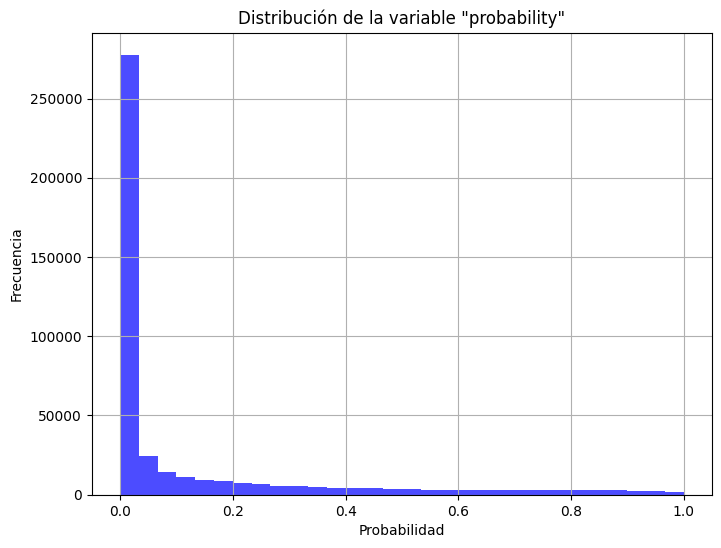

In [51]:
# Graficamos la distribución
plt.figure(figsize=(8,6))
plt.hist(data= df_customers_no_credit_card, x='probability', bins=30, color='blue', alpha=0.7)
plt.title('Distribución de la variable "probability"')
plt.xlabel('Probabilidad')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

In [52]:
df_customers_no_credit_card

,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,num_products_contracts,p_cuenta_bancaria,cuentas_sum,p_inversion,inversion_sum,p_financiacion,financiacion_sum,profit_cuentas,profit_inversion,profit_financiacion,gender,mes_partition,mes_nombre_partition,grupo_edad,median_salary,region_code,entry_channel,active_customer,segment,categoria_antiguedad,sale_credit_card,sale_short_term_deposit,sale_loans,sale_mortgage,sale_funds,sale_securities,sale_long_term_deposit,sale_em_account_pp,sale_payroll,sale_pension_plan,sale_payroll_account,sale_emc_account,sale_debit_card,sale_em_account_p,sale_em_acount,probability
pk_cid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
657826,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,H,5,May,Adultos,"54,493.380",Lleida,Otros,1,02 - PARTICULARES,Más de 3 años,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.876
657817,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,V,5,May,Adultos jóvenes,"120,141.600",Barcelona,Otros,0,03 - UNIVERSITARIO,0-3 meses,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.025
657905,0,0,0,0,0,1,0,0,0,0,0,0,0,1,2,1,1,1,1,0,0,10,40,0,H,5,May,Longevos,"154,059.090",Madrid,KAT,1,01 - TOP,2-3 años,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0.563
657336,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,V,5,May,Adultos jóvenes,"108,223.410",Madrid,KAT,1,02 - PARTICULARES,0-3 meses,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.304
657147,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,H,5,May,Adultos mayores,"104,881.710",Madrid,KAT,0,02 - PARTICULARES,1-2 años,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.540
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1166765,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,V,5,May,Jóvenes,"43,912.170",Zaragoza,KHE,0,03 - UNIVERSITARIO,2-3 años,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.001
1166764,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,V,5,May,Jóvenes,"23,334.990","Rioja, La",KHE,0,03 - UNIVERSITARIO,2-3 años,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0.023
1166763,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,H,5,May,Adultos,"87,930.930",Zaragoza,KHE,1,02 - PARTICULARES,2-3 años,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.011


In [53]:
df_sorted = df_customers_no_credit_card.sort_values(by='probability', ascending=False)

In [54]:
df_sorted

,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,num_products_contracts,p_cuenta_bancaria,cuentas_sum,p_inversion,inversion_sum,p_financiacion,financiacion_sum,profit_cuentas,profit_inversion,profit_financiacion,gender,mes_partition,mes_nombre_partition,grupo_edad,median_salary,region_code,entry_channel,active_customer,segment,categoria_antiguedad,sale_credit_card,sale_short_term_deposit,sale_loans,sale_mortgage,sale_funds,sale_securities,sale_long_term_deposit,sale_em_account_pp,sale_payroll,sale_pension_plan,sale_payroll_account,sale_emc_account,sale_debit_card,sale_em_account_p,sale_em_acount,probability
pk_cid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
330599,0,0,1,1,0,0,0,1,1,1,1,1,0,0,7,1,4,1,2,1,1,40,80,60,H,5,May,Adultos mayores,"314,597.850",Madrid,KFA,1,02 - PARTICULARES,2-3 años,0,0,0,1,1,0,0,0,1,1,1,1,1,0,0,1.000
1138522,0,0,1,0,0,0,0,1,1,1,0,1,0,0,5,1,3,1,1,1,1,30,40,60,H,5,May,Adultos jóvenes,"200,296.020",Barcelona,KFC,1,03 - UNIVERSITARIO,2-3 años,0,0,0,1,0,0,0,0,1,1,1,0,1,0,0,0.999
1365792,0,0,0,0,1,0,0,0,0,0,1,1,0,1,4,1,3,1,1,0,0,30,40,0,V,5,May,Adultos,"79,247.460",Zaragoza,RED,1,02 - PARTICULARES,1-2 años,0,0,0,0,0,1,0,0,0,0,1,1,1,0,1,0.999
1126704,0,0,1,0,0,0,0,1,1,1,0,1,0,0,5,1,3,1,1,1,1,30,40,60,V,5,May,Adultos jóvenes,"121,044.780",Cantabria,KFC,1,02 - PARTICULARES,Más de 3 años,0,0,0,1,0,0,0,0,1,1,1,0,1,0,0,0.999
1114268,0,0,0,0,0,0,0,1,1,1,1,1,0,0,5,1,4,1,1,0,0,40,40,0,H,5,May,Adultos,"31,628.820",Asturias,KAT,1,02 - PARTICULARES,Más de 3 años,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0.999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1440840,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,H,5,May,Jóvenes,"124,326.480",Murcia,KHQ,0,03 - UNIVERSITARIO,6-9 meses,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000
1279284,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,H,5,May,Jóvenes,"36,753.300",Palencia,KHE,0,03 - UNIVERSITARIO,1-2 años,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.000
1294124,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,H,5,May,Jóvenes,"35,315.070",Palencia,KHE,0,03 - UNIVERSITARIO,1-2 años,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.000


In [55]:
# Seleccionar los 10,000 clientes sin tarjeta de crédito con mayor probabilidad de compra
top_customers_no_credit_card = df_customers_no_credit_card.nlargest(10000, 'probability')

In [56]:
top_customers_no_credit_card

,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,num_products_contracts,p_cuenta_bancaria,cuentas_sum,p_inversion,inversion_sum,p_financiacion,financiacion_sum,profit_cuentas,profit_inversion,profit_financiacion,gender,mes_partition,mes_nombre_partition,grupo_edad,median_salary,region_code,entry_channel,active_customer,segment,categoria_antiguedad,sale_credit_card,sale_short_term_deposit,sale_loans,sale_mortgage,sale_funds,sale_securities,sale_long_term_deposit,sale_em_account_pp,sale_payroll,sale_pension_plan,sale_payroll_account,sale_emc_account,sale_debit_card,sale_em_account_p,sale_em_acount,probability
pk_cid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
330599,0,0,1,1,0,0,0,1,1,1,1,1,0,0,7,1,4,1,2,1,1,40,80,60,H,5,May,Adultos mayores,"314,597.850",Madrid,KFA,1,02 - PARTICULARES,2-3 años,0,0,0,1,1,0,0,0,1,1,1,1,1,0,0,1.000
1138522,0,0,1,0,0,0,0,1,1,1,0,1,0,0,5,1,3,1,1,1,1,30,40,60,H,5,May,Adultos jóvenes,"200,296.020",Barcelona,KFC,1,03 - UNIVERSITARIO,2-3 años,0,0,0,1,0,0,0,0,1,1,1,0,1,0,0,0.999
1365792,0,0,0,0,1,0,0,0,0,0,1,1,0,1,4,1,3,1,1,0,0,30,40,0,V,5,May,Adultos,"79,247.460",Zaragoza,RED,1,02 - PARTICULARES,1-2 años,0,0,0,0,0,1,0,0,0,0,1,1,1,0,1,0.999
1126704,0,0,1,0,0,0,0,1,1,1,0,1,0,0,5,1,3,1,1,1,1,30,40,60,V,5,May,Adultos jóvenes,"121,044.780",Cantabria,KFC,1,02 - PARTICULARES,Más de 3 años,0,0,0,1,0,0,0,0,1,1,1,0,1,0,0,0.999
1114268,0,0,0,0,0,0,0,1,1,1,1,1,0,0,5,1,4,1,1,0,0,40,40,0,H,5,May,Adultos,"31,628.820",Asturias,KAT,1,02 - PARTICULARES,Más de 3 años,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0.999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1089787,0,0,0,0,0,0,0,0,1,1,1,0,0,0,3,1,2,1,1,0,0,20,40,0,V,5,May,Longevos,"57,136.260",Córdoba,KFC,1,02 - PARTICULARES,Más de 3 años,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0.866
1042017,0,0,0,0,0,0,0,0,0,0,0,1,0,1,2,1,2,0,0,0,0,20,0,0,V,5,May,Adultos jóvenes,"94,863.570",Madrid,KFA,1,02 - PARTICULARES,Más de 3 años,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0.866
1094313,0,0,0,1,0,0,0,0,0,0,1,0,0,0,2,1,1,1,1,0,0,10,40,0,V,5,May,Adultos jóvenes,"106,857.150",Barcelona,KFC,1,02 - PARTICULARES,Más de 3 años,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0.866
